# Repeat Until Success

### Dynamic circuits - Intermediate

## Background
This tutorial demonstrates how certain IBM Quantum systems (those that support dynamic circuits) use mid-circuit measurements to produce a circuit that repeatedly attempts its setup until a syndrome measurement reveals that it has been successful.

Build an abstract circuit that uses the non-parameterized gate set $\{H,X,S,Toffoli\}$ to construct a heralded $R_X(\theta)$ gate on a target qubit, where $\theta$ satisfies $\cos \theta =\frac{3}{5}$. Each iteration of the circuit has a finite chance of success, but because successes are heralded, dynamic circuit capabilities are used to repeat the setup until it succeeds.

## Requirements
Before starting this tutorial, ensure that you have the following installed:
- Qiskit SDK v1.0 or later, with visualization support (
    ```bash
    pip install 'qiskit[visualization]'
    ```
    )
- Qiskti Runtime 0.22 or later (pip install qiskit-ibm-runtime)

## Step 1: Map classical inputs to a quantum problem

In [1]:
# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Qiskit Runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

A single trial of the probabilistic gate has the following form:

In [2]:
controls = QuantumRegister(2,name="control")
target = QuantumRegister(1,name="target")

mid_measure =ClassicalRegister(2,name="mid")
final_measure = ClassicalRegister(1,name="final")

circuit=QuantumCircuit(controls, target, mid_measure,final_measure)

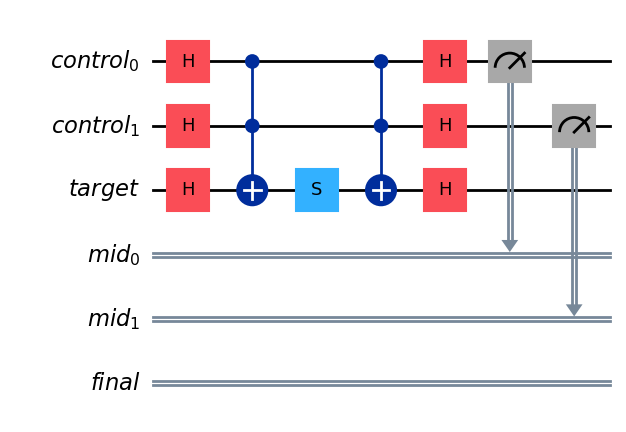

In [3]:
def trial(circuit,target,controls, measures):
    """Probabilistically perform an Rx gate for an angle that is an irrational multiple of pi."""
    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls,target)
    circuit.s(target)
    circuit.ccx(*controls,target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls,measures)

trial(circuit,target,controls,mid_measure)
circuit.draw(output="mpl",style='iqp',cregbundle=False)

If both control bit measurements return 0, the gate $R_X(\theta)$ with $\cos \theta=\frac{3}{5}$ is applied. If any of the measurements are $1$, gate $X$ is applied, which is a failure. This is the heralding; you can tell from the measurement whether the correct gate was applied, without disturbing the coherence of the target qubit. Without fully reproducing the mathematics, the success probability of this gate is:

$P_{\text{success}} = \frac{|3+\iota|^2}{|3+\iota|^2+3|1-\iota|^2}=\frac{5}{8}$

If there is a failutre, reset the "dirty" state and start again. Because you know what is applied in the case of a failure you can use this knowledge to reset efficiently without using a general hardware reset. For the two quxillary qubits, this is an $X$ gate conditioned on its respective measurements being $1$. IBM hardware has a special fast path for when qubits are conditioned on the result of their own measurement, so this is more efficient than most control flows.

In [4]:
def reset_controls(circuit,controls, measures):
    """Reset the controlling qubits if they are in |1>."""
    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])

Qiskit cannot directly represent an inequality condition, which is required for this exercise. You only need to repeat if the mid-circuit measurement result was not the bitstring "00". Instead, you can create an if statement with the condition mid_measure=="00", pass an empty block, and then use the else branch to perform the necessary logic.

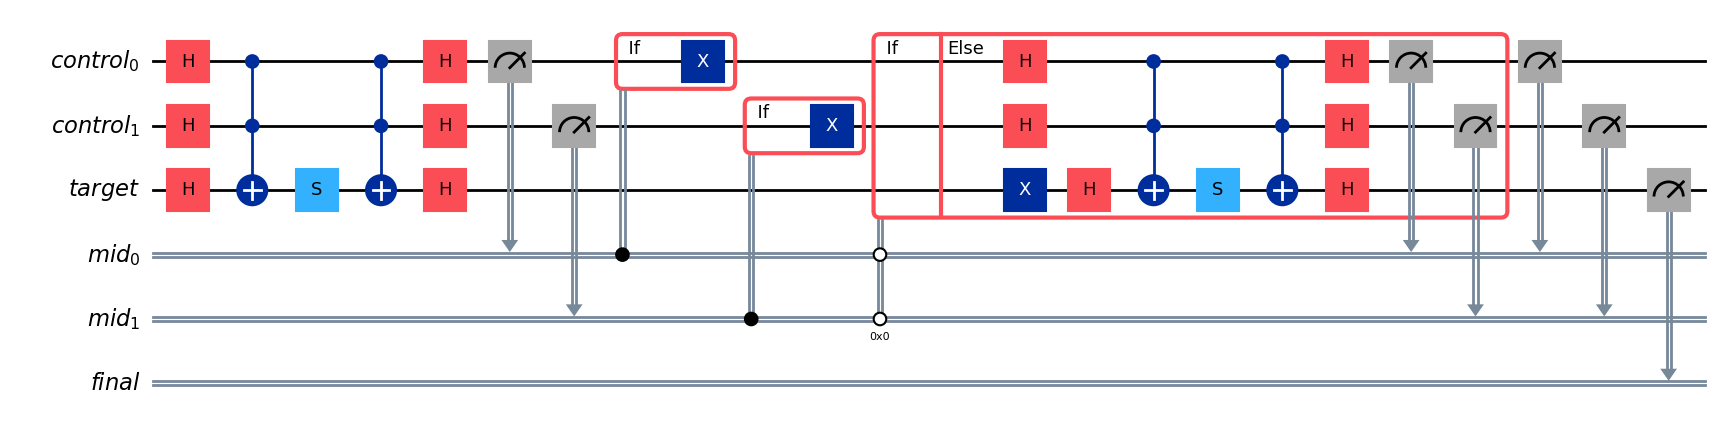

In [15]:
max_trials = 2

# Manuall add the rest of the trials. In the future, you can use a dynamic 'while' loop to do this, but for now, statically add each loop iteration with a manual condition check on each one.
# This involves more classical synchronizations than the while loop, but will suffice for now.

for _ in range (max_trials-1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure,0b00)) as else_:
        # This is the success path, but Qiskit can't directly represent a negative condition yet, so we have an empty 'true' block in order to use the 'else' branch.
        pass
    with else_:
        # First reset the target.
        circuit.x(target)
        # Then repeat the trail.
        trial(circuit,target,controls, mid_measure)

# Measure the control qubits again to ensure you get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, measure the target, to check that you're getting the desired rotation.
circuit.measure(target, final_measure)

circuit.draw(output="mpl",style="iqp",cregbundle=False)

## Step 2: optimize problem for Quantum execution

To reduce the total job execution time, V2 primitives only accept circuits and observables that conforms to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables)

### Convert to ISA input

In [17]:
# To run on hardware, select the backend with the fewest number

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(f">>> Connect to {backend.name} backend.")

>>> Connect to ibm_kyiv backend.


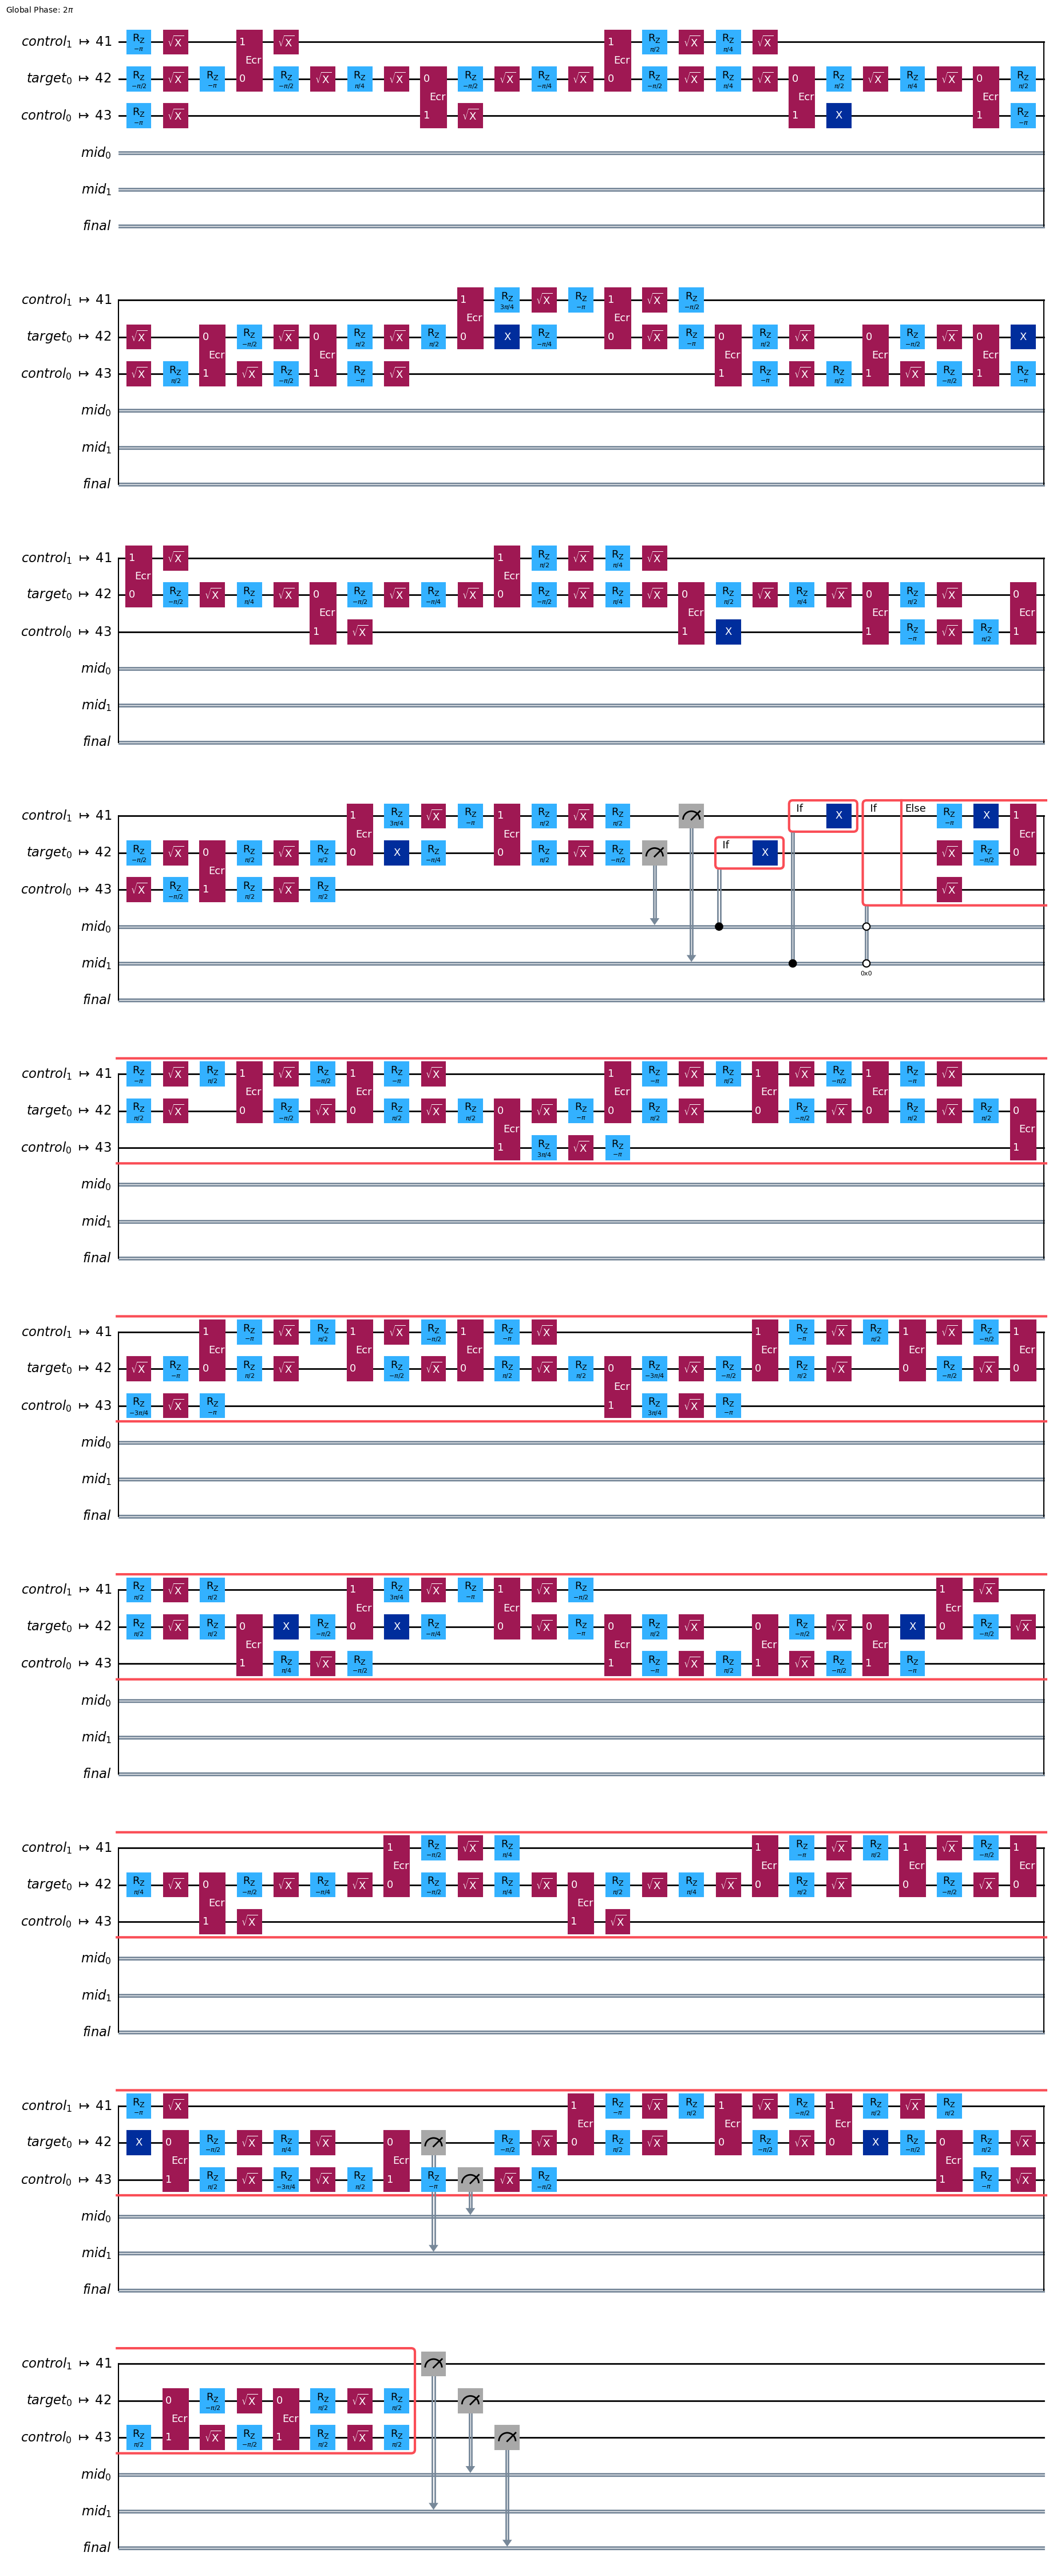

In [19]:
# Circuits must obey the ISA of a particular backend

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw(output="mpl",style="iqp",idle_wires=False,cregbundle=False)

## Step 3: Execute using Qiskit primitives

In [20]:
sampler = Sampler(backend)
job=sampler.run([isa_circuit],)
job.job_id()

'czcn70cb7tt0008gj050'

In [22]:
hardware_counts=job.result()[0]

data_mid = job.result()[0].data.mid
data_final = job.result()[0].data.final

print(f">>>Hardware counts for mid: {data_mid.get_counts()}")
print(f">>> Hardware counts for final: {data_final.get_counts()}")

>>>Hardware counts for mid: {'00': 2802, '10': 388, '11': 441, '01': 465}
>>> Hardware counts for final: {'1': 2408, '0': 1688}


In [23]:
from collections import defaultdict

merged_data=defaultdict(int)
for bs1,bs2 in zip(data_mid.get_bitstrings(), data_final.get_bitstrings()):
    merged_data[f"{bs1}-{bs2}"]+=1

print(f">>>Harware merged data: {dict(merged_data)}")

>>>Harware merged data: {'00-1': 1723, '00-0': 1079, '10-1': 238, '11-1': 233, '10-0': 150, '01-0': 251, '11-0': 208, '01-1': 214}


### Step 4: Post-process, return result in classical format

A successful result in one in which the measurements on the two controls end in the 00 state. You can filter those out and see how many successes will result. This is a type of post-selection. In the complete repeat-until-success circuit with a dynamic while loop, this would not be necessary as you would be guaranteed a success. However, in the interim, you can use the probabilities to examing the quality of the output and verify that the probabilities are as expected.

In [24]:
def marginalize_successes(counts):
    """Split the full output 'counts' dictionary into two separate dictionaries, marginalizing the results to leave only the target qubit's state."""

    successes=defaultdict(int)
    failures=defaultdict(int)

    for key,value in counts.items():
        if key.startswith("00"):
            successes[key[-1]]+=value
        else:
            failures[key[-1]]+=value

    return successes,failures

In [25]:
hw_successes, hw_failures = marginalize_successes(merged_data)

expected_successes = 1 - (1 - 5/8)**max_trials
actual_successes = sum(hw_successes.values()) / sum(merged_data.values())
print(f"Expected success rate {expected_successes:5.3f}.  Actual rate {actual_successes:5.3f}.")

Expected success rate 0.859.  Actual rate 0.684.


In [26]:
actual_probability = hw_successes["1"] / sum(hw_successes.values())
print(f"Expected |1> probability: 0.2.  Actual probability {actual_probability:5.3f}.")

Expected |1> probability: 0.2.  Actual probability 0.615.
